In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines', 'Proline']

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [3]:
from sklearn.preprocessing import RobustScaler

rsc = RobustScaler()
X_train_rsc = rsc.fit_transform(X_train)
X_test_rsc = rsc.transform(X_test)

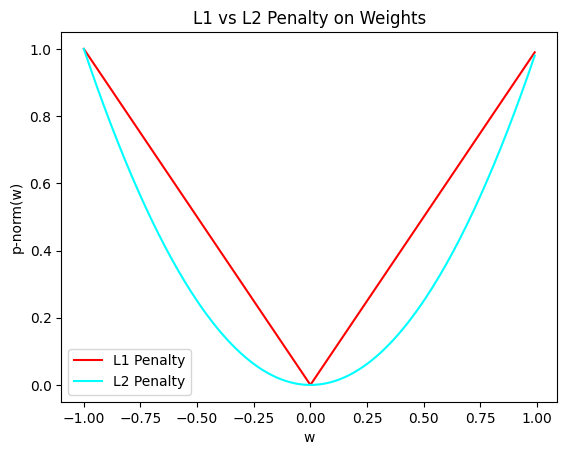

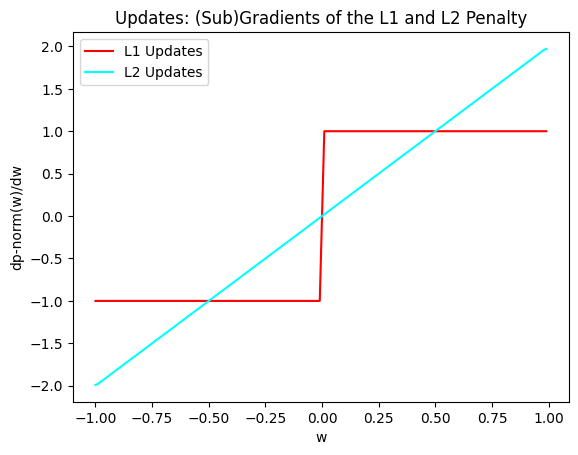

In [4]:
step_size=0.01
x_range = np.arange(-1, 1, step=step_size)

sns.lineplot(x=x_range,y=np.abs(x_range), color='red', label="L1 Penalty")
sns.lineplot(x=x_range,y=x_range ** 2, color='cyan', label="L2 Penalty")
plt.xlabel("w")
plt.ylabel("p-norm(w)")
plt.title("L1 vs L2 Penalty on Weights")
plt.show()

L1_deriv = np.gradient(np.abs(x_range), step_size)
L2_deriv = np.gradient(x_range ** 2, step_size)

sns.lineplot(y=L1_deriv, x=x_range, color='red', label="L1 Updates")
sns.lineplot(y=L2_deriv, x=x_range, color='cyan', label="L2 Updates")
plt.xlabel("w")
plt.ylabel("dp-norm(w)/dw")
plt.title("Updates: (Sub)Gradients of the L1 and L2 Penalty")
plt.show()

$L_1$ regularlization adds an $L_1$ norm ($L_p$ where $p = 1$) of the weights to the cost function/loss, which penalizes having non-zero weights (more than an $L_2$ norm in the $(-1, 1)$ range). Furthermore weights are uniformly encouraged to be pushed to zero when they are not on the optimal isocurves of the non-regularized part of the loss function. An $L_2$ norm weakens the push towards 0 as the weights get lower, in a linear fashion, since updates are proportional to the gradient. Since the $L_2$ norm is a quadratic penalty, the updates get linearly smaller as the weights begin to approach 0, unlike the uniform updates towards 0 in an $L_1$ norm.

$L_1$ regularlization is also known as LASSO, which promotes a sparse set of model parameters. It corresponds to a Bayesian Laplace prior of $\frac{1}{2 \tau} \exp(- ||w||_1 / \tau)$. $L_2$ regularlization, also known as Ridge, or weight decay, arises from a Bayesian Gaussian prior on the parameters. It encourages small parameters, preventing overfitting as well, but doesn't encourage the same dimensionality reduction as an $L_1$ does.

The encouragement from the prior towards 0 is far more significant in the case of an $L_1$ norm as demonstrated below.

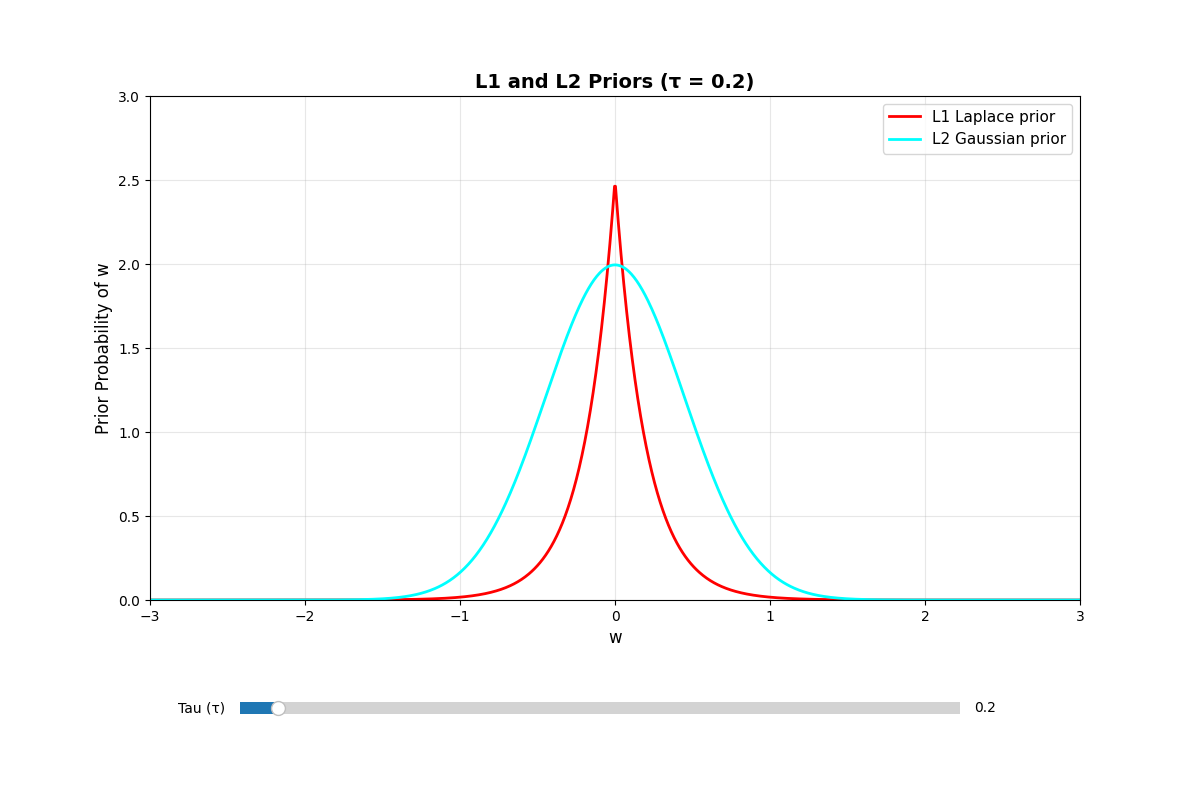

Use the slider to adjust the tau parameter and see how it affects both priors:
- Smaller tau: More peaked distributions (stronger regularization)
- Larger tau: More spread out distributions (weaker regularization)
- L1 (red): Sharp peak at zero, promotes sparsity
- L2 (cyan): Smooth bell curve, promotes small weights


In [ ]:
%matplotlib widget
# Needs ipympl - install with pip or conda
from matplotlib.widgets import Slider

# Set up the plot style
plt.style.use('default')

# Define the x range
x_range = np.linspace(-3, 3, 1000)

# Initial tau value
initial_tau = 0.2

# Calculate initial priors
def calculate_priors(tau):
    L1_prior = (1 / (2 * tau)) * np.exp(-np.abs(x_range) / tau)
    L2_prior = (1 / (tau * np.sqrt(2 * np.pi))) * np.exp(-(x_range ** 2) / (2 * tau))
    return L1_prior, L2_prior

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(bottom=0.25)

# Initial plot
L1_initial, L2_initial = calculate_priors(initial_tau)
line1, = ax.plot(x_range, L1_initial, 'red', linewidth=2, label='L1 Laplace prior')
line2, = ax.plot(x_range, L2_initial, 'cyan', linewidth=2, label='L2 Gaussian prior')

# Customize the plot
ax.set_xlabel("w", fontsize=12)
ax.set_ylabel("Prior Probability of w", fontsize=12)
ax.set_title(f"L1 and L2 Priors (τ = {initial_tau})", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Set axis limits
ax.set_xlim(-3, 3)
ax.set_ylim(0, 3)

# Create slider axis
slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])
tau_slider = Slider(
    slider_ax, 
    'Tau (τ)', 
    0.1, 
    2.0, 
    valinit=initial_tau,
    valfmt='%.1f'
)

# Update function for the slider
def update(val):
    tau = tau_slider.val
    L1_prior, L2_prior = calculate_priors(tau)
    
    # Update the line data
    line1.set_ydata(L1_prior)
    line2.set_ydata(L2_prior)
    
    # Update the title
    ax.set_title(f"L1 and L2 Priors (τ = {tau:.1f})", fontsize=14, fontweight='bold')
    
    # Adjust y-axis limits dynamically
    max_y = max(np.max(L1_prior), np.max(L2_prior))
    ax.set_ylim(0, max_y * 1.1)
    
    # Redraw the plot
    fig.canvas.draw_idle()

# Connect the slider to the update function
tau_slider.on_changed(update)

# Show the plot
plt.show()

# Optional: Add some text explanation
print("Use the slider to adjust the tau parameter and see how it affects both priors:")
print("- Smaller tau: More peaked distributions (stronger regularization)")
print("- Larger tau: More spread out distributions (weaker regularization)")
print("- L1 (red): Sharp peak at zero, promotes sparsity")
print("- L2 (cyan): Smooth bell curve, promotes small weights")

In [6]:
from sklearn.linear_model import LogisticRegression

lr0 = LogisticRegression(penalty='l2', C=1e42, solver='liblinear', multi_class='ovr')
lr1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
lr2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', multi_class='ovr')

lr0.fit(X_train_rsc, y_train)
lr1.fit(X_train_rsc, y_train)
lr2.fit(X_train_rsc, y_train)

print(f"Training accuracy was - L1 Regularized: {lr1.score(X_train_rsc, y_train)*100}%, L2 Regularized: {lr2.score(X_train_rsc, y_train)*100}%, Unregularized: {lr0.score(X_train_rsc, y_train)*100}%")
print(f"Test accuracy was - L1 Regularized: {lr1.score(X_test_rsc, y_test)*100}%, L2 Regularized: {lr2.score(X_test_rsc, y_test)*100}%, Unregularized: {lr0.score(X_test_rsc, y_test)*100}%")

Training accuracy was - L1 Regularized: 100.0%, L2 Regularized: 99.19354838709677%, Unregularized: 100.0%
Test accuracy was - L1 Regularized: 100.0%, L2 Regularized: 98.14814814814815%, Unregularized: 98.14814814814815%


c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [7]:
# Since this is a 'OvR' strategy (i.e. one-versus-rest) the first intercept entry for each regressor gives us a classification of Class 1 vs Classes 2 and 3, second  on is Class 2 vs 1 and 3
# and the third is for Class 3 (or not Class 3)
print(lr0.intercept_)
print(lr1.intercept_)
print(lr2.intercept_)

# Clearly, L1 encourages sparseness, L2 encourages smaller values and Unreguarlized does neither

[ -7.48402288   0.2868981  -15.30028544]
[-1.51374407  0.         -2.88558728]
[-1.31894043 -0.10391229 -2.40188224]


In [ ]:
print(lr0.coef_)
print()
print(lr1.coef_)
print()
print(lr2.coef_)

# Clearly, L1 encourages sparseness, L2 encourages smaller values and Unreguarlized does neither in the coefficients as well

[[  9.28011501   2.58341539   6.14638262  -9.28994887   1.66797468
    3.9055977    9.08682387   1.46068179  -2.94875093  -0.46531088
   -2.45705226   6.85543028   9.97196989]
 [-10.74865008  -4.96258222  -9.06754896   7.47030198  -2.41193932
   -4.01119552   5.12341953   1.14094684   5.7631569  -13.47782893
    8.42069418  -3.60198526 -17.07762716]
 [  2.05365987   0.11318796   5.81119118   2.40297169  -2.79615716
    0.66143244 -11.76298371  -1.57888497  -7.03758007   6.33158634
   -9.5457716   -2.27139437   3.86790287]]

[[ 1.97725041  0.          0.7931799  -1.39694808  0.          0.
   2.00445774  0.         -0.00707606  0.          0.          0.64376004
   2.49230103]
 [-1.70198461 -0.77997726 -1.34819248  0.69405861  0.          0.
   0.          0.          0.65824303 -2.61894258  1.08349443  0.
  -2.77697465]
 [ 0.          0.24366168  0.48287423  0.          0.          0.
  -2.83569879  0.         -0.55666931  1.73130327 -1.94918124 -0.03687719
   0.        ]]

[[ 1.569925

c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\

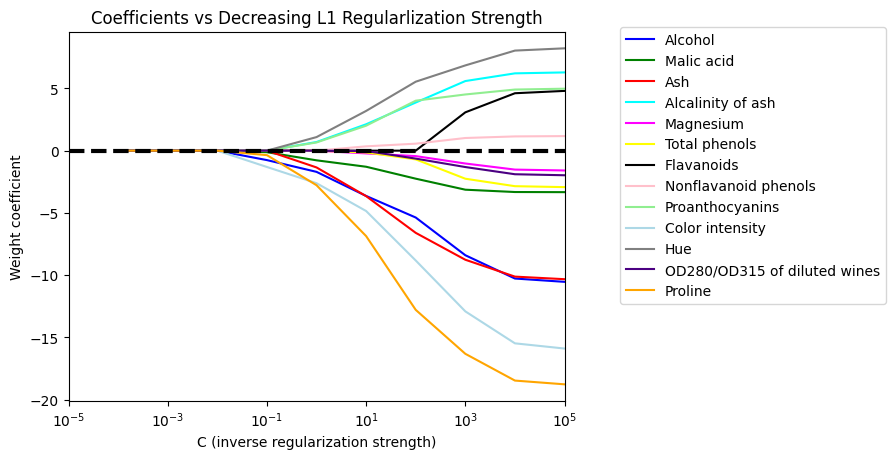

In [15]:
%matplotlib inline
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr1 = LogisticRegression(penalty='l1', C=10.**c,
                           solver='liblinear',
                           multi_class='ovr', random_state=0)
    lr1.fit(X_train_rsc, y_train)
    weights.append(lr1.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.title("Coefficients vs Decreasing L1 Regularlization Strength")
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadit\miniconda3\envs\dataexercises\Lib\

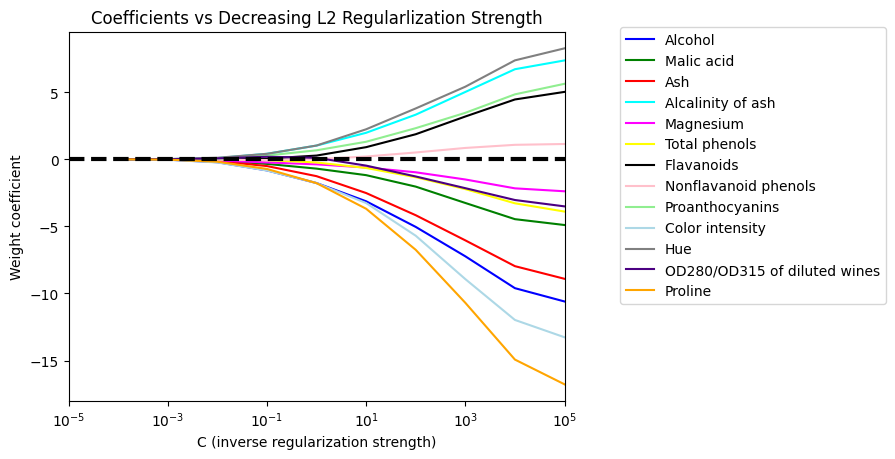

In [16]:
%matplotlib inline
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr2 = LogisticRegression(penalty='l2', C=10.**c,
                           solver='liblinear',
                           multi_class='ovr', random_state=0)
    lr2.fit(X_train_rsc, y_train)
    weights.append(lr2.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.title("Coefficients vs Decreasing L2 Regularlization Strength")
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()